In [1]:
import yaml
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from skopt.space import Real, Integer
from skopt import BayesSearchCV

from sklearn.metrics import confusion_matrix
from sklearn import tree
from matplotlib import pyplot as plt
import pickle

In [2]:
# Read config file
with open("config.yaml", 'r') as configuration:
    config = yaml.safe_load(configuration)

In [3]:
# Read and concat the data
PL_20_21 = pd.read_csv('data\\PL_20_21.csv', sep=',')
PL_19_20 = pd.read_csv('data\\PL_19_20.csv', sep=',')
PL_18_19 = pd.read_csv('data\\PL_18_19.csv', sep=',')
PL_17_18 = pd.read_csv('data\\PL_17_18.csv', sep=',')
BL_20_21 = pd.read_csv('data\\BL_20_21.csv', sep=',')
BL_19_20 = pd.read_csv('data\\BL_19_20.csv', sep=',')
BL_18_19 = pd.read_csv('data\\BL_18_19.csv', sep=',')
SP_20_21 = pd.read_csv('data\\SP_20_21.csv', sep=',')
SP_19_20 = pd.read_csv('data\\SP_19_20.csv', sep=',')
SP_18_19 = pd.read_csv('data\\SP_18_19.csv', sep=',')
SP_17_18 = pd.read_csv('data\\SP_17_18.csv', sep=',')
IT_20_21 = pd.read_csv('data\\IT_20_21.csv', sep=',')
IT_19_20 = pd.read_csv('data\\IT_20_21.csv', sep=',')

data = pd.concat([PL_20_21,PL_19_20,PL_18_19,PL_17_18,BL_20_21,BL_19_20,BL_18_19,SP_20_21,SP_19_20,SP_18_19,SP_17_18,IT_20_21,IT_19_20])
data = data.reset_index(drop=True)
data = data.dropna(how='any')
data

,Date,HomeTeam,AwayTeam,FTR,h_course,d_course,a_course,h_pts_avg3,h_pts_avg5,h_pts_avg7,...,a_rc_std7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja,position_dst
18,2020-09-26,Crystal Palace,Everton,A,3.75,3.25,2.10,1.000000,1.2,0.857143,...,0.534522,3.000000,3.000000,1.000000,16.000000,7.500000,8.000000,2.000000,2.0,3.0
19,2020-09-26,West Brom,Chelsea,D,9.00,4.75,1.36,0.000000,0.2,0.285714,...,1.399708,1.500000,1.500000,1.500000,7.500000,15.500000,2.500000,7.000000,9.0,8.0
21,2020-09-27,Sheffield United,Leeds,A,2.70,3.30,2.62,2.000000,1.2,1.285714,...,0.534522,1.500000,3.500000,3.500000,8.000000,18.000000,7.000000,1.500000,8.0,9.0
22,2020-09-27,Tottenham,Newcastle,D,1.45,4.50,7.00,2.000000,1.8,1.857143,...,0.699854,1.500000,1.000000,1.500000,10.500000,14.000000,7.500000,4.000000,12.0,4.0
24,2020-09-27,West Ham,Wolves,H,3.60,3.50,2.05,2.333333,2.0,1.428571,...,0.880631,1.500000,1.500000,1.500000,10.500000,11.500000,8.000000,5.500000,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700,2021-05-23,Bologna,Juventus,A,10.50,7.00,1.22,0.333333,0.6,0.571429,...,1.293626,2.027027,1.972973,1.000000,13.405405,10.108108,5.270270,4.972973,5.0,7.0
4701,2021-05-23,Napoli,Verona,D,1.18,7.50,13.00,2.333333,2.2,2.428571,...,1.049781,1.135135,1.135135,1.270270,9.324324,11.405405,5.432432,4.405405,10.0,5.0
4702,2021-05-23,Sassuolo,Lazio,H,1.90,4.33,3.25,2.000000,2.0,2.285714,...,1.551826,1.837838,1.648649,1.432432,12.189189,9.162162,4.702703,4.810811,6.0,2.0
4703,2021-05-23,Spezia,Roma,D,5.00,4.60,1.57,1.666667,1.2,1.000000,...,1.195229,1.675676,1.783784,1.432432,12.459459,9.189189,4.675676,5.000000,7.0,8.0


In [4]:
# Dictionary for mapping target
str2idx = {'H':0, 'D':1, 'A':2}
idx2str = {0:'H', 1:'D', 2:'A'}
dicts2translate = {'str2idx' : str2idx,
                   'idx2str' : idx2str }

data = data.replace({'FTR': str2idx})

data_label = data['FTR']
data = data.drop(['FTR','Date','HomeTeam','AwayTeam'], axis=1)
data

,h_course,d_course,a_course,h_pts_avg3,h_pts_avg5,h_pts_avg7,h_pts_std3,h_pts_std5,h_pts_std7,h_gz_avg3,...,a_rc_std7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja,position_dst
18,3.75,3.25,2.10,1.000000,1.2,0.857143,1.414214,1.469694,1.355262,1.333333,...,0.534522,3.000000,3.000000,1.000000,16.000000,7.500000,8.000000,2.000000,2.0,3.0
19,9.00,4.75,1.36,0.000000,0.2,0.285714,0.000000,0.400000,0.451754,1.000000,...,1.399708,1.500000,1.500000,1.500000,7.500000,15.500000,2.500000,7.000000,9.0,8.0
21,2.70,3.30,2.62,2.000000,1.2,1.285714,1.414214,1.469694,1.484615,0.666667,...,0.534522,1.500000,3.500000,3.500000,8.000000,18.000000,7.000000,1.500000,8.0,9.0
22,1.45,4.50,7.00,2.000000,1.8,1.857143,1.414214,1.469694,1.355262,2.333333,...,0.699854,1.500000,1.000000,1.500000,10.500000,14.000000,7.500000,4.000000,12.0,4.0
24,3.60,3.50,2.05,2.333333,2.0,1.428571,0.942809,1.264911,1.399708,2.333333,...,0.880631,1.500000,1.500000,1.500000,10.500000,11.500000,8.000000,5.500000,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700,10.50,7.00,1.22,0.333333,0.6,0.571429,0.471405,0.489898,0.494872,1.000000,...,1.293626,2.027027,1.972973,1.000000,13.405405,10.108108,5.270270,4.972973,5.0,7.0
4701,1.18,7.50,13.00,2.333333,2.2,2.428571,0.942809,0.979796,0.903508,2.666667,...,1.049781,1.135135,1.135135,1.270270,9.324324,11.405405,5.432432,4.405405,10.0,5.0
4702,1.90,4.33,3.25,2.000000,2.0,2.285714,1.414214,1.264911,1.160577,2.000000,...,1.551826,1.837838,1.648649,1.432432,12.189189,9.162162,4.702703,4.810811,6.0,2.0
4703,5.00,4.60,1.57,1.666667,1.2,1.000000,0.942809,0.979796,0.925820,2.666667,...,1.195229,1.675676,1.783784,1.432432,12.459459,9.189189,4.675676,5.000000,7.0,8.0


In [5]:
data = data.drop(['h_course','d_course','a_course'], axis=1)

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, data_label, test_size=0.30, random_state=20)

In [7]:
model = xgb.XGBRegressor(objective='multi:softmax',
                        num_class=3)

In [8]:
params = {
        'learning_rate': Real(0.1, 0.3),
        'n_estimators': Integer(20, 80),
        'min_child_weight': Integer(10, 300),
        'gamma': Real(0.5,5),
        'colsample_bytree': Real(0.7, 0.95),
        'subsample': Real(0.7, 0.9),
        'max_depth': Integer(2,3),
        'lambda': Real(1,10)
        }

In [9]:
# BAYESIAN OPTIMIZATION
bayes_optim = BayesSearchCV(estimator=model,
                            search_spaces=params,
                            n_iter = 15,
                            n_jobs=-1,
                            cv=5,
                            verbose=1,
                            random_state=19)

bayes_optim.fit(X_train, y_train)


print('\nBEST PARAMETERS:',bayes_optim.best_params_, '\n')

print('BEST SCORE:',bayes_optim.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[18:00:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in X

In [10]:
# Manualy hiperparam tuning
#bayes_optim.best_params_['learning_rate'] = 0.2


In [11]:
# DataFrames to DMatrix
X_train = xgb.DMatrix(X_train, label=y_train)
X_test = xgb.DMatrix(X_test, label=y_test)

# Parameters definition
param = {'max_depth': bayes_optim.best_params_['max_depth'],
         'eta': bayes_optim.best_params_['learning_rate'],
         'gamma':bayes_optim.best_params_['gamma'],
         'min_child_weight':bayes_optim.best_params_['min_child_weight'],
         'colsample_bytree':bayes_optim.best_params_['colsample_bytree'],
         'subsample':bayes_optim.best_params_['subsample'],
         'lambda':bayes_optim.best_params_['lambda'],
         'objective': 'multi:softprob',
         'eval_metric' : ['auc','merror'],
         'num_class' : 3
        }
evallist = [(X_test, 'test'), (X_train, 'train')]

xgb_model = xgb.train(param, X_train, bayes_optim.best_params_['n_estimators'], evallist)

[0]	test-auc:0.63647	test-merror:0.49925	train-auc:0.66413	train-merror:0.48481
[1]	test-auc:0.65703	test-merror:0.48869	train-auc:0.68344	train-merror:0.47188
[2]	test-auc:0.65588	test-merror:0.49095	train-auc:0.68571	train-merror:0.47091
[3]	test-auc:0.66116	test-merror:0.48567	train-auc:0.69281	train-merror:0.47641
[4]	test-auc:0.66245	test-merror:0.48944	train-auc:0.69449	train-merror:0.47285
[5]	test-auc:0.66821	test-merror:0.48718	train-auc:0.70074	train-merror:0.47059
[6]	test-auc:0.66786	test-merror:0.49547	train-auc:0.70179	train-merror:0.47253
[7]	test-auc:0.67222	test-merror:0.48718	train-auc:0.70597	train-merror:0.46606
[8]	test-auc:0.67306	test-merror:0.49170	train-auc:0.70976	train-merror:0.46606
[9]	test-auc:0.67398	test-merror:0.49246	train-auc:0.71202	train-merror:0.46315
[10]	test-auc:0.67556	test-merror:0.48944	train-auc:0.71352	train-merror:0.46412
[11]	test-auc:0.67993	test-merror:0.48718	train-auc:0.71608	train-merror:0.46348
[12]	test-auc:0.68110	test-merror:0.48

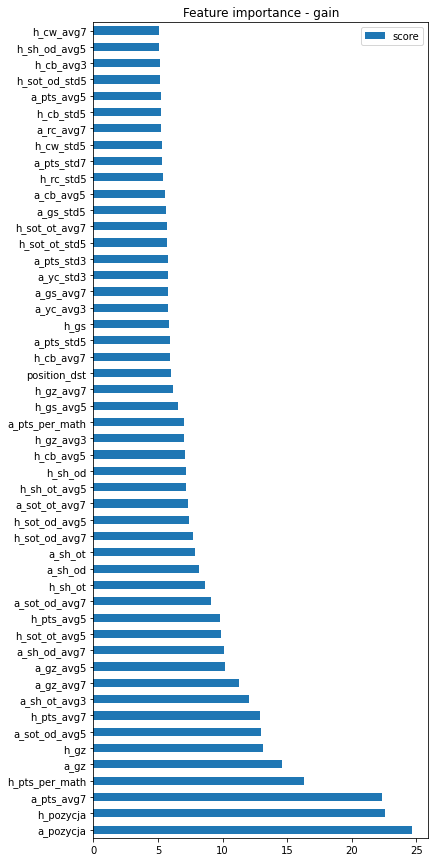

In [22]:
# Feature importance
feature_important = xgb_model.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_score = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)[:50]
data_score.plot(kind='barh', figsize=(6,15))
plt.title('Feature importance - gain')
plt.show()

In [23]:
train_probabilities = pd.DataFrame(xgb_model.predict(X_train))
train_probabilities['FTR'] = train_probabilities.idxmax(axis = 1)

test_probabilities = pd.DataFrame(xgb_model.predict(X_test))
test_probabilities['FTR'] = test_probabilities.idxmax(axis = 1)


# ACCURACY
print('TRAIN:', sum(np.array(train_probabilities['FTR']) == np.array(y_train))/len(np.array(y_train)))
print('TEST:', sum(np.array(test_probabilities['FTR']) == np.array(y_test))/len(np.array(y_test)))

# Confucion matrix
print('TRAIN:\n', confusion_matrix(np.array(y_train), np.array(train_probabilities['FTR'])))
print('TEST:\n', confusion_matrix(np.array(y_test), np.array(test_probabilities['FTR'])))

TRAIN: 0.5866192630898514
TEST: 0.5294117647058824
TRAIN:
 [[1140   33  189]
 [ 460  106  226]
 [ 338   33  569]]
TEST:
 [[438  20 109]
 [202  20  91]
 [185  17 244]]


In [24]:
train_probabilities = pd.DataFrame(xgb_model.predict(X_train))
#train_preds['FTR'] = train_preds.idxmax(axis = 1)
#train_preds = train_preds.replace({'FTR': idx2str})

test_probabilities = pd.DataFrame(xgb_model.predict(X_test))
#test_preds['FTR'] = test_preds.idxmax(axis = 1)
#test_preds = test_preds.replace({'FTR': idx2str})

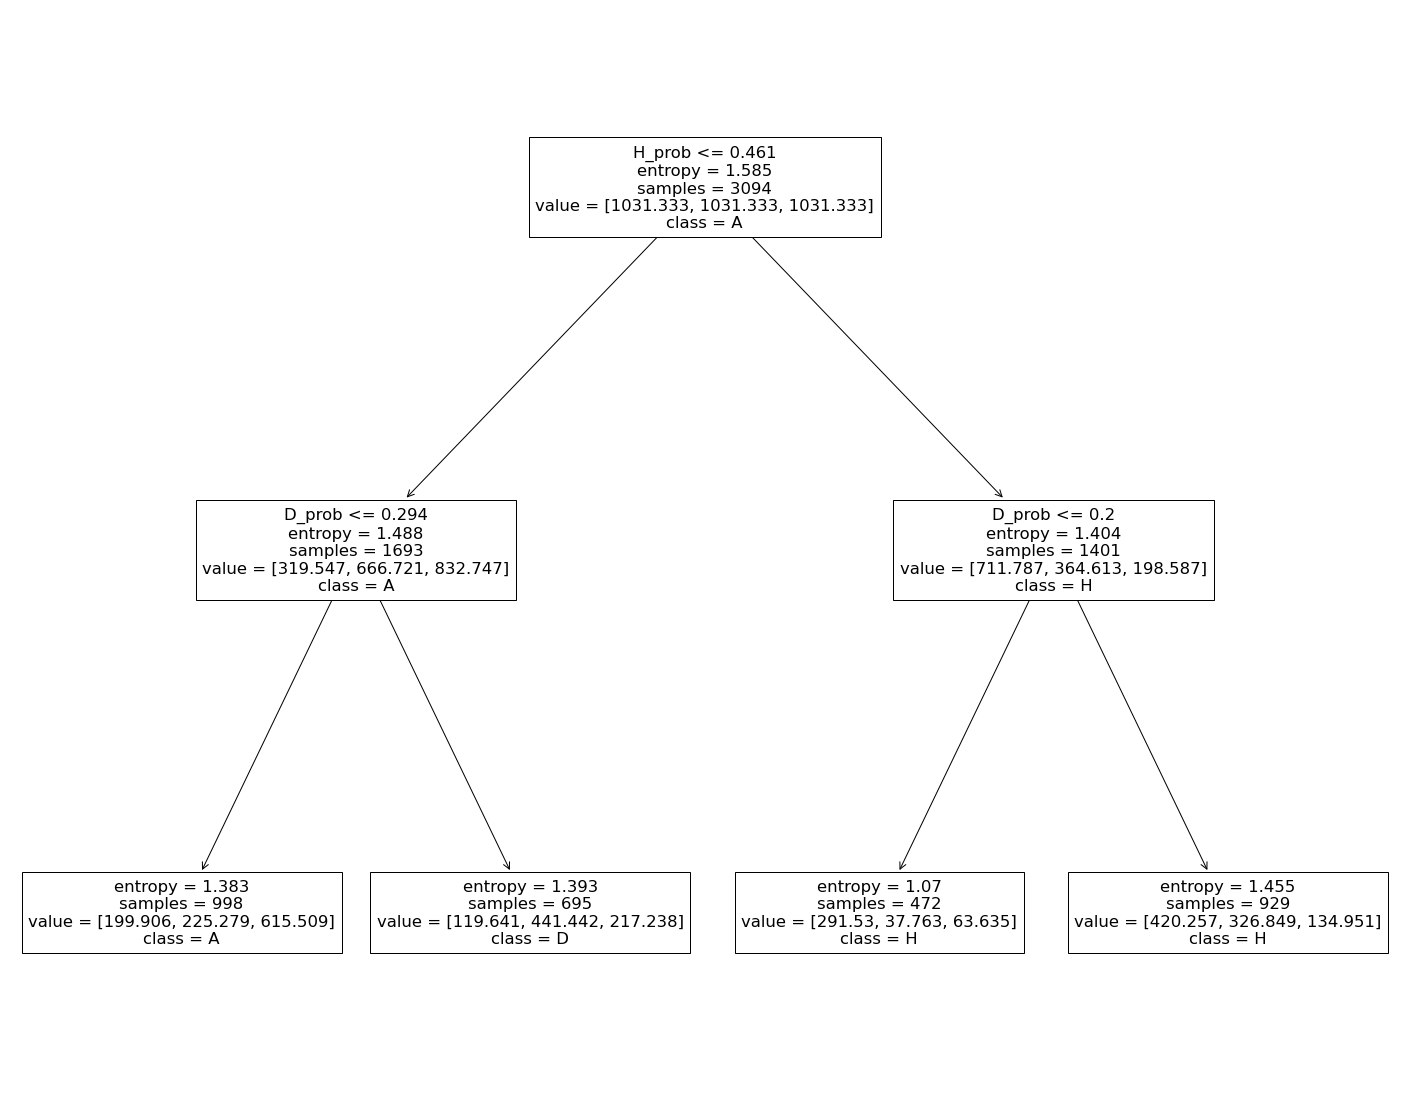

In [25]:
# Decision tree
decision_tree = DecisionTreeClassifier(criterion='entropy',
                             class_weight = 'balanced',
                             max_depth = 2,
                             min_samples_leaf = 0.03
                            )
decision_tree.fit(train_probabilities, np.array(y_train))

# Plot tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree, 
                   feature_names=['H_prob','D_prob','A_prob'],
                   class_names=['H','D','A'])

In [26]:
# Predictions after decision tree
tree_preds_train = decision_tree.predict(train_probabilities)
tree_preds_test = decision_tree.predict(test_probabilities)

In [28]:
# ACCURACY
print('TRAIN:', sum(np.array(tree_preds_train) == np.array(y_train))/len(np.array(y_train)))
print('TEST:', sum(np.array(tree_preds_test) == np.array(y_test))/len(np.array(y_test)))

# Confucion matrix
print('TRAIN:\n', confusion_matrix(np.array(y_train), np.array(tree_preds_train)))
print('TEST:\n', confusion_matrix(np.array(y_test), np.array(tree_preds_test)))

TRAIN: 0.59469941822883
TEST: 0.5067873303167421
TRAIN:
 [[940 158 264]
 [280 339 173]
 [181 198 561]]
TEST:
 [[357  79 131]
 [135  84  94]
 [112 103 231]]


In [29]:
# Save model and components
pickle.dump(xgb_model, open('model\\xgb_model.pkl', "wb"))
pickle.dump(decision_tree, open('model\\tree_model.pkl', "wb"))
pickle.dump(dicts2translate, open('model\\dicts2translate.pkl', "wb"))